# Read and preprocess raw data

## import and functions

In [1]:
import uproot
import awkward as ak
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import torch

In [2]:
def normalize_features(x, eps=1e-8):
    mean = np.mean(x, axis=(0, 1), keepdims=True)
    std = np.std(x, axis=(0, 1), keepdims=True)
    x_norm = (x - mean) / (std + eps)
    return x_norm, mean, std

def normalize_2d(x, eps=1e-8):
    mean = np.nanmean(x, axis=0, keepdims=True)
    std = np.nanstd(x, axis=0, keepdims=True)
    return (x - mean) / (std + eps), mean, std
    
def summarize_features(X, recoPixelTrackFeatures_names):
    summary = []
    for i, name in enumerate(recoPixelTrackFeatures_names):
        x = X[:, i]
        x_clean = x[~np.isnan(x)]
        min_val = np.min(x_clean)
        max_val = np.max(x_clean)
        mean_val = np.mean(x_clean)
        std_val = np.std(x_clean)
        zero_frac = np.sum(np.isclose(x_clean, 0)) / len(x_clean)
        nan_frac = np.sum(np.isnan(x)) / len(x)
        s = skew(x_clean)
        summary.append({
            "feature": name,
            "min": min_val,
            "max": max_val,
            "mean": mean_val,
            "std": std_val,
            "zeros(%)": 100*zero_frac,
            "NaNs(%)": 100*nan_frac,
            "skew": s
        })
    return summary

def print_summary_table(summary, sort_by="skew", top=10):
    import pandas as pd
    df = pd.DataFrame(summary)
    df_sorted = df.sort_values(by=sort_by, key=lambda x: np.abs(x), ascending=False)
    print(df_sorted.head(top).to_string(index=False))
    return df_sorted

def flag_outliers(summary, std_threshold=100, skew_threshold=5, zero_frac_threshold=80):
    issues = []
    for row in summary:
        if np.isnan(row["std"]) or row["std"] == 0:
            issues.append((row["feature"], "Constant or NaN std"))
        if abs(row["skew"]) > skew_threshold:
            issues.append((row["feature"], f"Highly skewed ({row['skew']:.2f})"))
        if row["zeros(%)"] > zero_frac_threshold:
            issues.append((row["feature"], f"Mostly zeros ({row['zeros(%)']:.1f}%)"))
        if abs(row["max"] - row["min"]) > std_threshold * row["std"]:
            issues.append((row["feature"], "Extreme outlier range"))
    print("\n Potentially problematic features:")
    for f, msg in issues:
        print(f" - {f:30s}: {msg}")
    return issues

def clip_outliers(x, low=0.001, high=0.999):
    lo, hi = np.percentile(x, [100*low, 100*high])
    return np.clip(x, lo, hi)

def plot_feature_distributions(
    X_ref,
    feature_names,
    y=None,
    X_cmp=None,
    labels=("Reference", "Comparison"),
    n_cols=4,
    bins=50,
    figsize=(16, 12),
    density=True,
    alpha_ref=0.6,
    alpha_cmp=0.4,
):
    """
    Plot feature distributions for one or two datasets.

    Parameters
    ----------
    X_ref : np.ndarray
        Reference dataset of shape (n_samples, n_features).
    feature_names : list of str
        Names of the features to plot.
    y : np.ndarray, optional
        Binary labels (True/False or 1/0). If given, separate histograms by class.
    X_cmp : np.ndarray, optional
        Comparison dataset (same shape as X_ref) to overlay.
    labels : tuple(str, str)
        Labels for the legend corresponding to (X_ref, X_cmp).
    n_cols : int
        Number of subplot columns.
    bins : int
        Number of histogram bins.
    figsize : tuple
        Overall figure size.
    density : bool
        Whether to normalize histograms to density.
    alpha_ref : float
        Transparency for reference histograms.
    alpha_cmp : float
        Transparency for comparison histograms.
    """

    n_features = X_ref.shape[1]
    n_rows = int(np.ceil(n_features / n_cols))
    plt.figure(figsize=figsize)

    for i, name in enumerate(feature_names):
        plt.subplot(n_rows, n_cols, i + 1)

        # Determine plotting mode
        if y is not None:
            mask_true = (y == 1)
            mask_fake = (y == 0)
            plt.hist(
                X_ref[mask_true, i], bins=bins, alpha=alpha_ref,
                label=f"{labels[0]} True", density=density
            )
            plt.hist(
                X_ref[mask_fake, i], bins=bins, alpha=alpha_ref,
                label=f"{labels[0]} Fake", density=density
            )
            if X_cmp is not None:
                plt.hist(
                    X_cmp[mask_true, i], bins=bins, alpha=alpha_cmp,
                    label=f"{labels[1]} True", density=density, linestyle="dashed"
                )
                plt.hist(
                    X_cmp[mask_fake, i], bins=bins, alpha=alpha_cmp,
                    label=f"{labels[1]} Fake", density=density, linestyle="dashed"
                )
        else:
            plt.hist(X_ref[:, i], bins=bins, alpha=alpha_ref, label=labels[0], density=density)
            if X_cmp is not None:
                plt.hist(X_cmp[:, i], bins=bins, alpha=alpha_cmp, label=labels[1], density=density)

        plt.title(name, fontsize=8)
        plt.tick_params(axis="x", labelsize=7)
        plt.tick_params(axis="y", labelsize=7)

    plt.tight_layout()
    plt.legend(fontsize=7)
    plt.show()

In [3]:
#INPUT_PATH = "ext.root"
INPUT_PATH  = "/shared/data/100_tracks_train_dataset.root"
OUTPUT_PATH = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train-val_dataset.pt"
OUTPUT_PATH_TRAIN = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train_dataset.pt"
OUTPUT_PATH_VAL  = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_val_dataset.pt"
MAX_HITS = 16

LOW_PERCENTILE  = 0.001
HIGH_PERCENTILE = 0.999
EPSILON = 1.e-8

## Read data from file

In [4]:
# Open the ROOT file
file = uproot.open(INPUT_PATH)
print(file.keys())

print("")
print("-----------------------------------------------")
print("-----------------------------------------------")
print("")

# Access the Events TTree
events = file["Events"]

# List branches in Events
print("Branches in Events:")

for branch in events.keys():
# Inspect first few entries
    print("   -", branch)

# Read all branches into an awkward array
data = events.arrays(library="ak")

['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']

-----------------------------------------------
-----------------------------------------------

Branches in Events:
   - run
   - luminosityBlock
   - event
   - bunchCrossing
   - orbitNumber
   - nGenJet
   - GenJet_eta
   - GenJet_mass
   - GenJet_phi
   - GenJet_pt
   - nGenPart
   - GenPart_genPartIdxMother
   - GenPart_statusFlags
   - GenPart_pdgId
   - GenPart_status
   - GenPart_eta
   - GenPart_mass
   - GenPart_phi
   - GenPart_pt
   - nhltPixelTrackRecHits
   - hltPixelTrackRecHits_globalX
   - hltPixelTrackRecHits_globalY
   - hltPixelTrackRecHits_globalZ
   - hltPixelTrackRecHits_globalErrX
   - hltPixelTrackRecHits_globalErrY
   - hltPixelTrackRecHits_globalErrZ
   - hltPixelTrackRecHits_globalR
   - hltPixelTrackRecHits_globalEta
   - hltPixelTrackRecHits_globalPhi
   - nhltPixelTrack
   - hltPixelTrack_isHighPurity
   - hltPixelTrack_isTight
   - hltPixelTrack_duplicate
   - hltPixelTrack_m

Decide which branches contain either input features or output labels

In [5]:
recHitBranches = [
    "hltPixelTrackRecHits_globalX",
    "hltPixelTrackRecHits_globalY",
    "hltPixelTrackRecHits_globalZ",
    "hltPixelTrackRecHits_globalErrX",
    "hltPixelTrackRecHits_globalErrY",
    "hltPixelTrackRecHits_globalErrZ",
    "hltPixelTrackRecHits_globalR",
    "hltPixelTrackRecHits_globalEta",
    "hltPixelTrackRecHits_globalPhi"
]

recoPixelTrackBranches = [
    "hltPixelTrack_matched",
    "hltPixelTrack_isHighPurity",
    "hltPixelTrack_nPixelHits",
    "hltPixelTrack_nTrkLays",
    "hltPixelTrack_charge",
    "hltPixelTrack_chi2",
    "hltPixelTrack_dXY",
    "hltPixelTrack_dZ",
    "hltPixelTrack_dZError",
    "hltPixelTrack_dsz",
    "hltPixelTrack_dszErr",
    "hltPixelTrack_dxyError",
    "hltPixelTrack_eta",
    "hltPixelTrack_etaErr",
    "hltPixelTrack_lambdaErr",
    "hltPixelTrack_ndof",
    "hltPixelTrack_phi",
    "hltPixelTrack_phiErr",
    "hltPixelTrack_pt",
    "hltPixelTrack_ptErr",
    "hltPixelTrack_qoverp",
    "hltPixelTrack_qoverpErr",
    "hltPixelTrack_vx",
    "hltPixelTrack_vy",
    "hltPixelTrack_vz",
    "hltPixelTrack_dzBS",
    "hltPixelTrack_dxyBS"
]

genPartBranches = [
    "nhltPixelTrack",
]

Read the branches from the file

In [6]:
# Convert Awkward arrays to (n_tracks, MAX_HITS) arrays and stack
recHitFeaturesList = []
for b in recHitBranches:
    arr = ak.to_numpy(ak.flatten(data[b])).reshape(-1,MAX_HITS)  # (n_tracks, MAX_HITS)
    recHitFeaturesList.append(arr)

recHitFeatures = np.stack(recHitFeaturesList, axis=2)  # (n_tracks, MAX_HITS, n_features)

# Create mask (1 = real hit, 0 = padded)
mask = np.isnan(recHitFeatures[:,:,0])  # (n_tracks, MAX_HITS)

# Replace NaNs with 0.0
recHitFeatures[mask] = 0
isRecHit = ~mask

recoPixelTrackList = []
for b in recoPixelTrackBranches:
    arr = ak.to_numpy(ak.flatten(data[b]))  # (n_tracks,)
    recoPixelTrackList.append(arr)

genPartList = []
for b in genPartBranches:
    arr = ak.to_numpy(data[b])  # (n_tracks,)
    genPartList.append(arr)

recoPixelTrackFeatures = np.stack(recoPixelTrackList[2:], axis=1)  # (n_tracks, n_features)
recoPixelTrackLabels = np.array(recoPixelTrackList[0])
recoPixelTrackIsHighPurity = np.array(recoPixelTrackList[1])
recoPixelTrackFeatures_names = recoPixelTrackBranches[2:]  # skip 'hltPixelTrack_matched and IsHP' (label)
genPart = np.array(genPartList)

In [7]:
print("recHitFeatures: ", recHitFeatures.shape)
print("recoPixelTrackFeatures: ", recoPixelTrackFeatures.shape)
print("isRecHit: ", isRecHit.shape)
print("GenPart: ", genPart[0].sum())

recHitFeatures:  (182801, 16, 9)
recoPixelTrackFeatures:  (182801, 25)
isRecHit:  (182801, 16)
GenPart:  182801


## Preprocessing

### RecoPixelTracks

Inspect the properties of recoPixelTrack features to look for potential problems

In [8]:
# Compute feature statistics
summary = summarize_features(recoPixelTrackFeatures, recoPixelTrackFeatures_names)
summary_df = print_summary_table(summary, sort_by="skew", top=15)

                 feature        min          max      mean         std  zeros(%)  NaNs(%)       skew
     hltPixelTrack_ptErr   0.010045 2.397397e+06 15.588523 5647.794922  0.000000      0.0 419.064972
        hltPixelTrack_pt   0.714977 8.865675e+03  1.737651   25.725933  0.000000      0.0 288.167419
  hltPixelTrack_dxyError   0.000739 1.023114e+02  0.032955    0.290512  0.000000      0.0 258.347717
    hltPixelTrack_phiErr   0.000152 3.137633e+01  0.009004    0.090525  0.000000      0.0 256.683319
      hltPixelTrack_chi2   0.003361 1.093829e+02  7.189980    6.443142  0.000000      0.0   2.912981
    hltPixelTrack_dszErr   0.000716 6.550348e-02  0.008014    0.004832  0.000000      0.0   2.209778
   hltPixelTrack_dZError   0.001879 9.999201e-01  0.077810    0.111885  0.000000      0.0   2.019468
 hltPixelTrack_qoverpErr   0.000473 3.790320e-02  0.008379    0.004146  0.000000      0.0   1.130826
 hltPixelTrack_lambdaErr   0.000017 2.205401e-03  0.000535    0.000382  0.000000      0.0  

In [9]:
issues = flag_outliers(summary)


 Potentially problematic features:
 - hltPixelTrack_dxyError        : Highly skewed (258.35)
 - hltPixelTrack_dxyError        : Extreme outlier range
 - hltPixelTrack_phiErr          : Highly skewed (256.68)
 - hltPixelTrack_phiErr          : Extreme outlier range
 - hltPixelTrack_pt              : Highly skewed (288.17)
 - hltPixelTrack_pt              : Extreme outlier range
 - hltPixelTrack_ptErr           : Highly skewed (419.06)
 - hltPixelTrack_ptErr           : Extreme outlier range


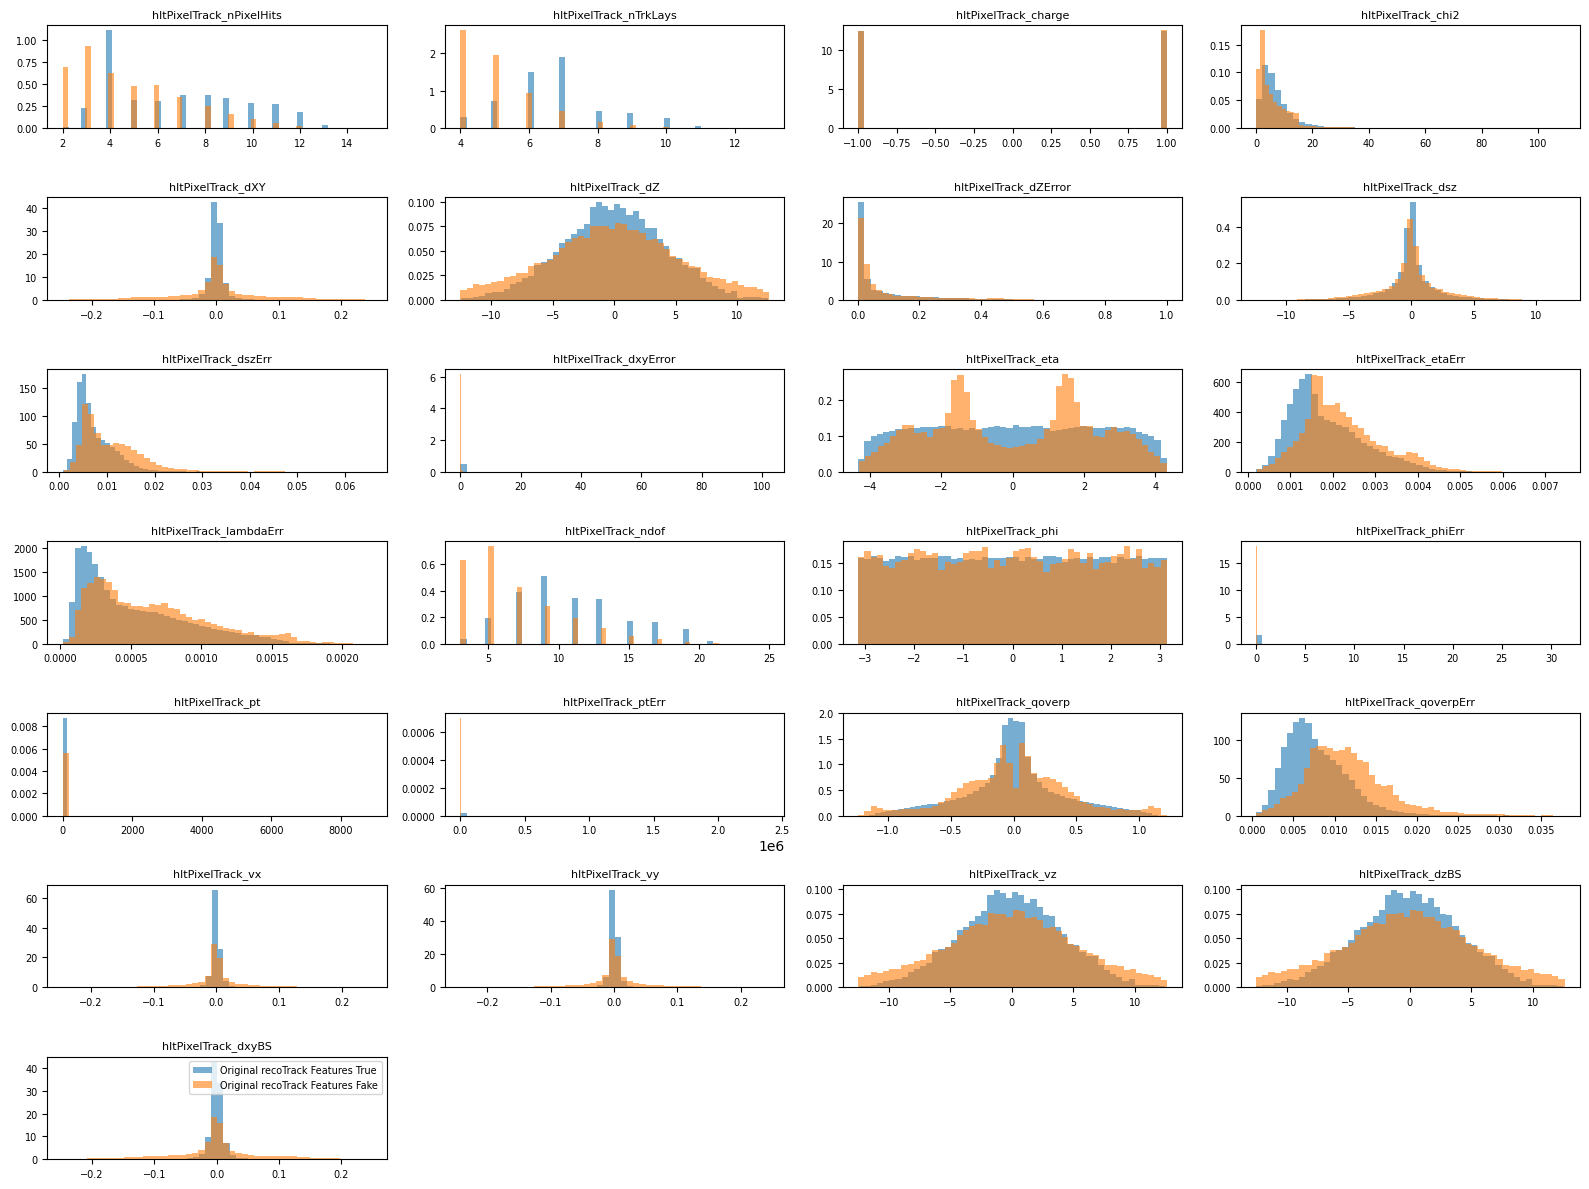

In [10]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeatures,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Original recoTrack Features",)
)

Apply clipping and log transformation where needed 

In [11]:
# Variables to log-transform and clip
log_vars = ["hltPixelTrack_pt", "hltPixelTrack_ptErr", 
            "hltPixelTrack_dxyError", "hltPixelTrack_phiErr", 
            "hltPixelTrack_chi2", "hltPixelTrack_dszErr",
            "hltPixelTrack_dZError", "hltPixelTrack_qoverpErr", "hltPixelTrack_lambdaErr", "hltPixelTrack_etaErr"]

recoPixelTrackFeatures_proc = recoPixelTrackFeatures.copy()
for i, name in enumerate(recoPixelTrackFeatures_names):
    if name in log_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x = np.log10(EPSILON+x)
        x = clip_outliers(x, low=LOW_PERCENTILE, high=HIGH_PERCENTILE)
        recoPixelTrackFeatures_proc[:, i] = x


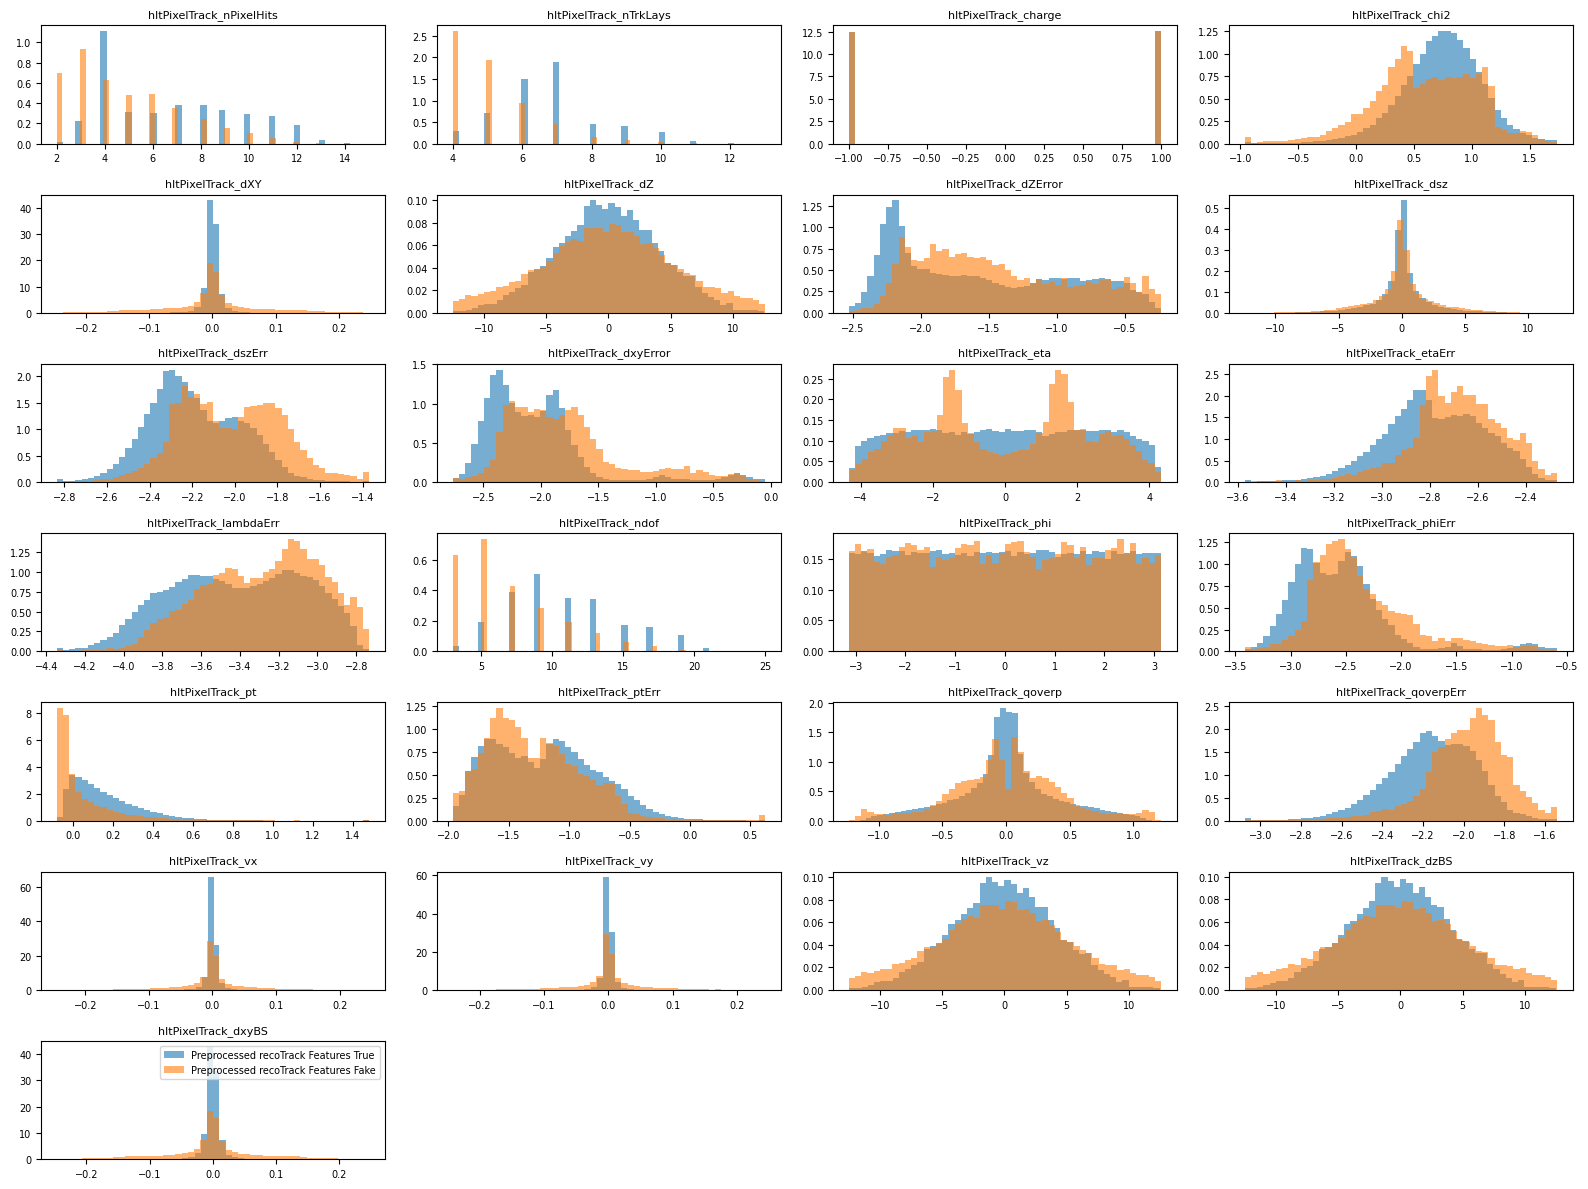

In [12]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeatures_proc,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Preprocessed recoTrack Features",)
)

In [13]:
# Variables to just clip
clip_vars = ["hltPixelTrack_dXY", "hltPixelTrack_dsz", 
            "hltPixelTrack_vx", "hltPixelTrack_vy"]
for i, name in enumerate(recoPixelTrackFeatures_names):
    if name in clip_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x = clip_outliers(x, low=LOW_PERCENTILE, high=HIGH_PERCENTILE)
        recoPixelTrackFeatures_proc[:, i] = x

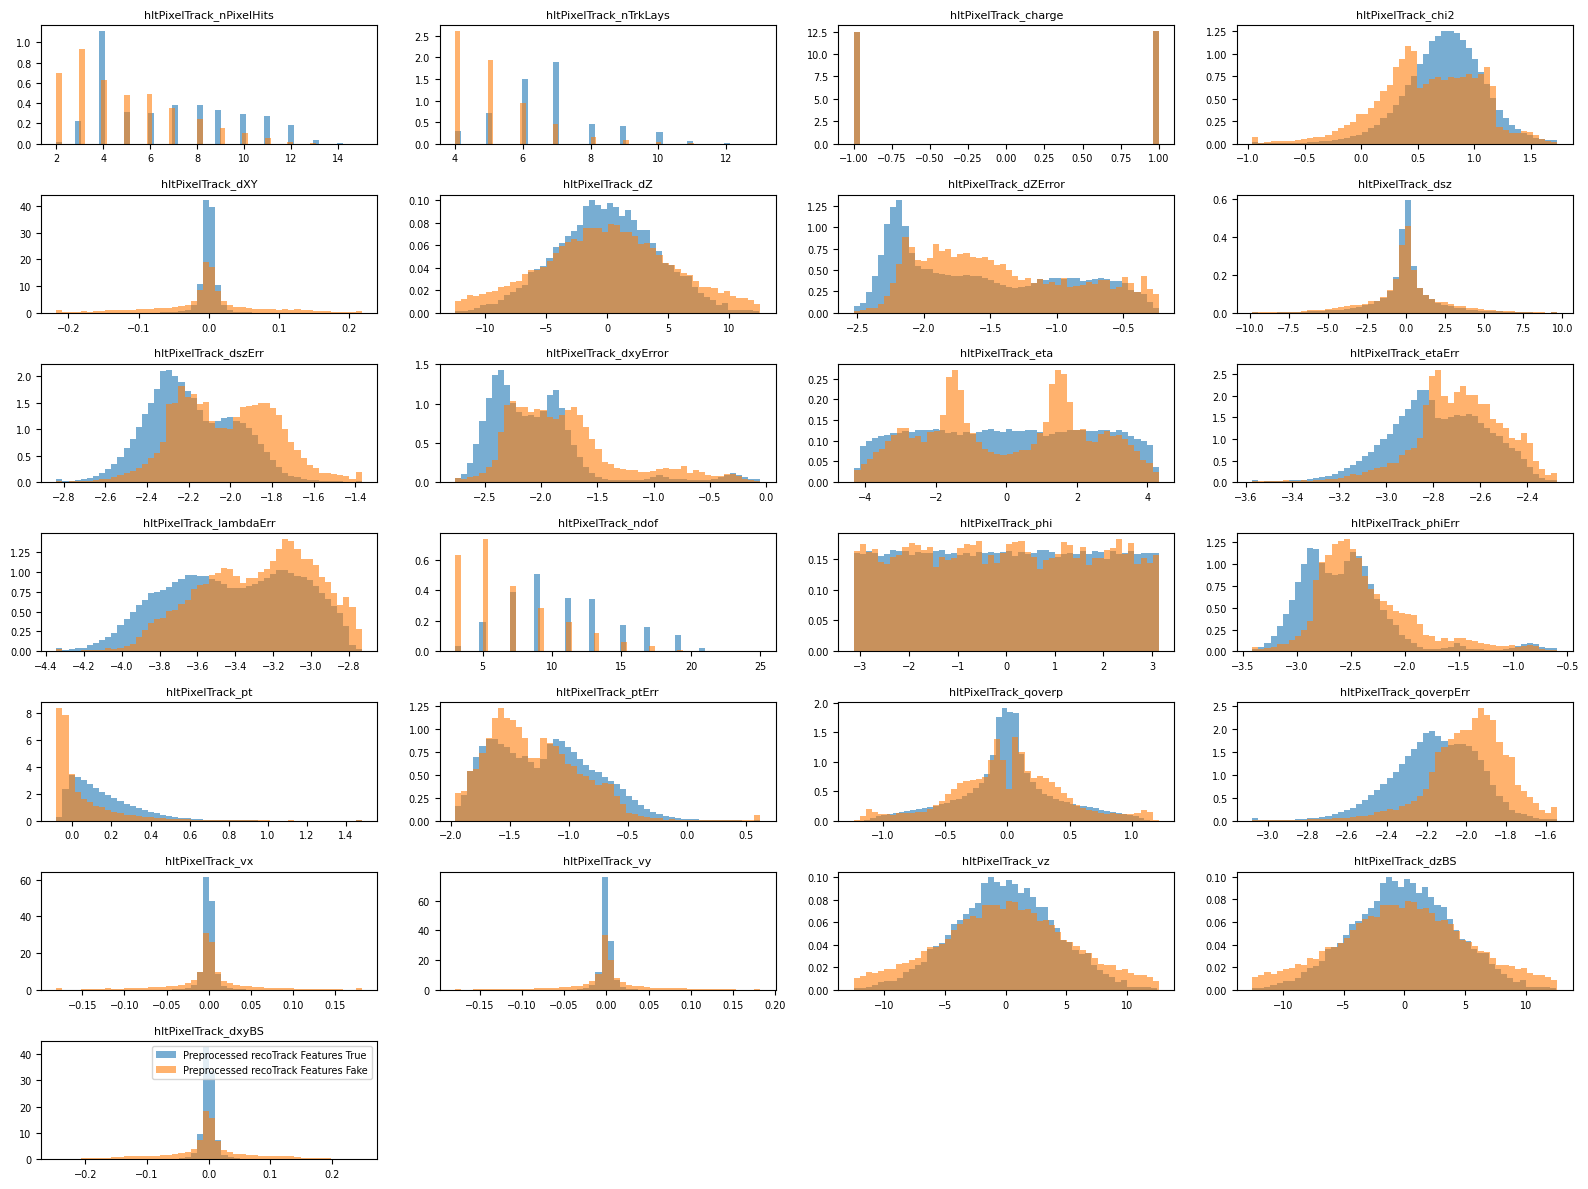

In [14]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeatures_proc,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Preprocessed recoTrack Features",)
)

Apply normalization

In [15]:
recoPixelTrackFeaturesNorm, recoPixelTrack_mean, recoPixelTrack_std = normalize_2d(recoPixelTrackFeatures_proc)

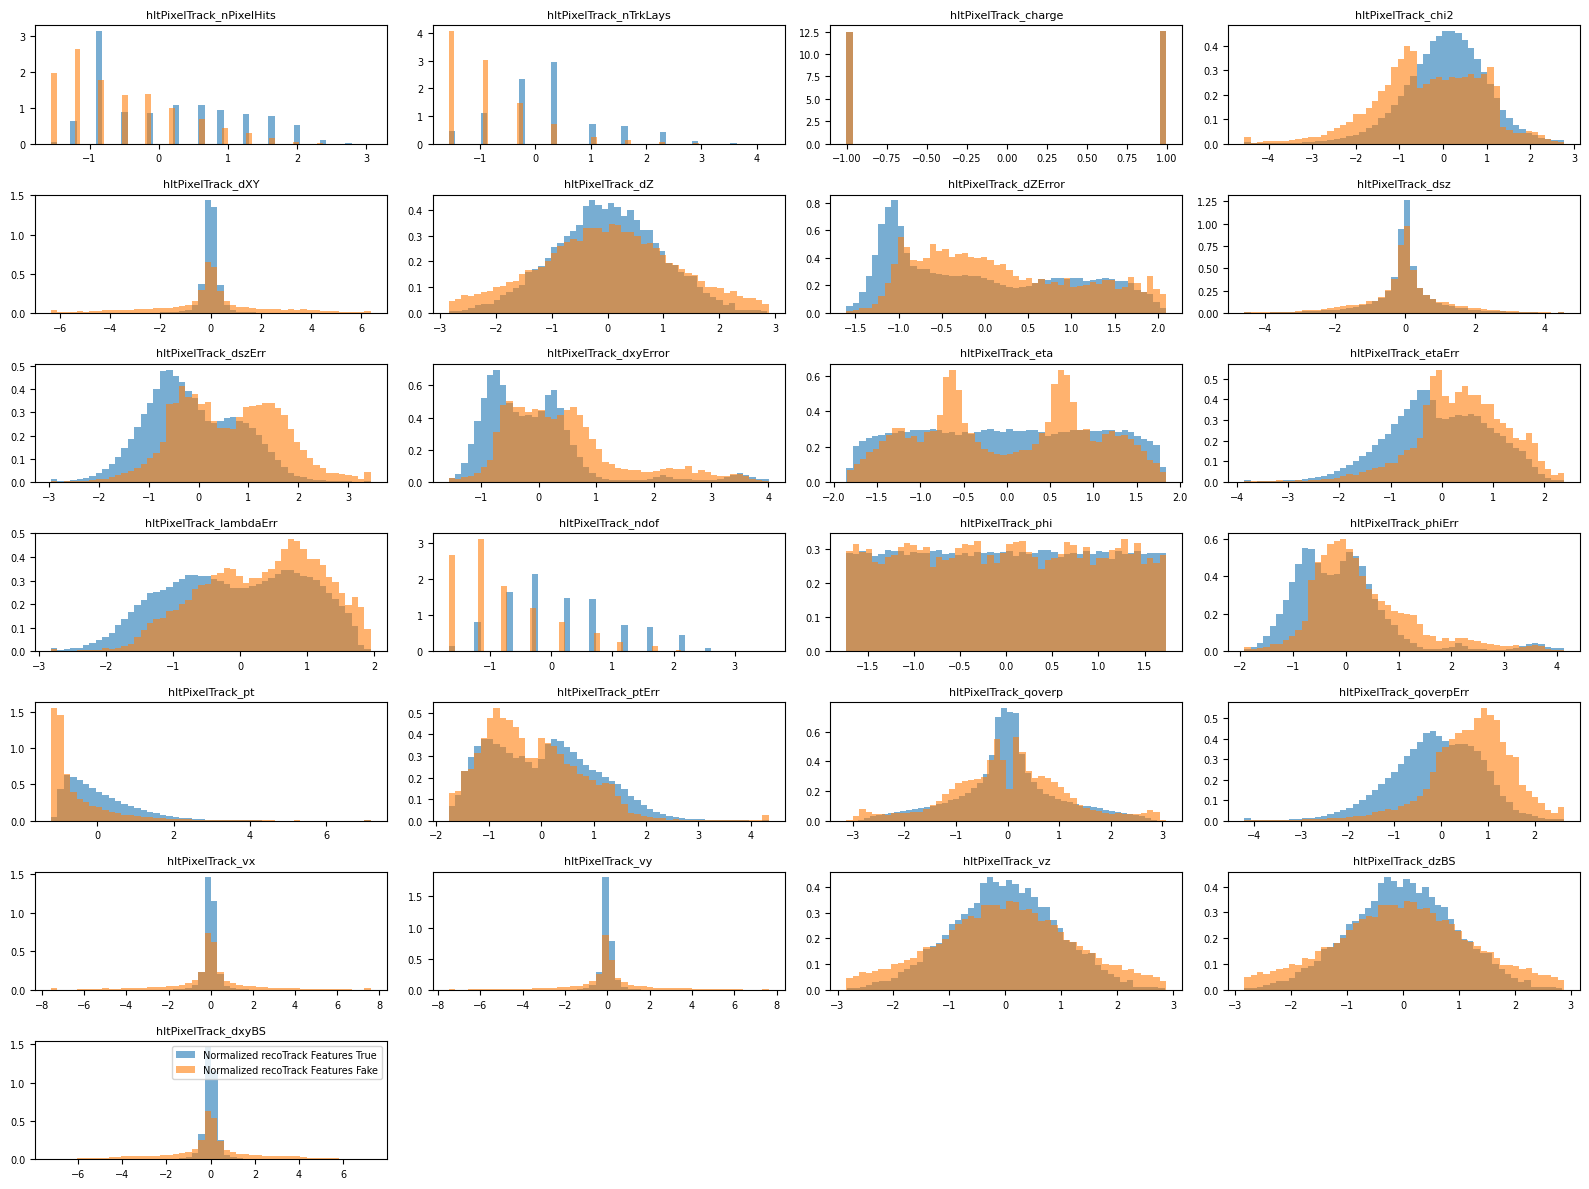

In [16]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeaturesNorm,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Normalized recoTrack Features",)
)

In [17]:
summary_norm = summarize_features(recoPixelTrackFeaturesNorm, recoPixelTrackFeatures_names)
summary_norm_df = print_summary_table(summary_norm, sort_by="skew", top=15)

                 feature       min      max          mean      std  zeros(%)  NaNs(%)      skew
        hltPixelTrack_pt -1.218994 7.174664 -1.918690e-06 1.000024       0.0      0.0  1.915624
  hltPixelTrack_dxyError -1.568944 4.004517 -6.819652e-05 1.000018       0.0      0.0  1.721033
    hltPixelTrack_phiErr -1.927288 4.137831 -1.142132e-05 1.000027       0.0      0.0  1.560603
      hltPixelTrack_chi2 -4.560196 2.773443  2.856667e-06 1.000024       0.0      0.0 -0.487937
 hltPixelTrack_qoverpErr -4.218083 2.629126 -8.035394e-05 1.000023       0.0      0.0 -0.487188
  hltPixelTrack_nTrkLays -1.565931 4.216804 -7.913158e-08 1.000570       0.0      0.0  0.486680
     hltPixelTrack_ptErr -1.763868 4.339769 -1.710411e-05 1.000014       0.0      0.0  0.485933
hltPixelTrack_nPixelHits -1.558146 3.066792 -3.973274e-08 1.000154       0.0      0.0  0.481755
      hltPixelTrack_ndof -1.671468 3.552289 -2.253748e-09 1.000015       0.0      0.0  0.428234
   hltPixelTrack_dZError -1.603097 2.098

In [18]:
issues = flag_outliers(summary_norm)


 Potentially problematic features:


### RecHits

In [19]:
def masked_flatten(feat3d, mask):
    """
    feat3d: (n_tracks, n_hits, n_features)
    mask:   (n_tracks, n_hits) boolean True=real, False=padded
    returns flat array of real values for each feature: list of arrays length n_features
    """
    n_features = feat3d.shape[2]
    flat_per_feature = []
    for f in range(n_features):
        vals = feat3d[:,:,f][mask]      # selects only real hits
        flat_per_feature.append(vals)
    return flat_per_feature


def summarize_recHits(feat3d, mask, feature_names):
    """
    Summarize statistics for recHit features.
    Returns a list of dicts (one dict per summary record).
    """
    n_tracks, n_hits, n_feats = feat3d.shape
    summary = []

    # global per-feature
    flat = masked_flatten(feat3d, mask)
    for f, arr in enumerate(flat):
        if arr.size == 0:
            continue
        summary.append({
            "feature": feature_names[f],
            "n": arr.size,
            "min": float(np.min(arr)),
            "max": float(np.max(arr)),
            "mean": float(np.mean(arr)),
            "std": float(np.std(arr)),
            "zeros(%)": 100.0 * np.sum(np.isclose(arr, 0.0)) / arr.size,
            "skew": float(skew(arr))
        })
    return summary


# --- Mask-aware transforms --------------------------------------------------

def compute_percentile_bounds(feat3d, mask, feature_idx, low=0.001, high=0.999):
    """
    Return (lo, hi).
    """

    vals = feat3d[:,:,feature_idx][mask]
    lo, hi = np.nanpercentile(vals, [100*low, 100*high])
    return (lo, hi)


def clip_outliers_3d(feat3d, mask, feature_idx, low=0.001, high=0.999):
    """Return a copy with clipped values (only real-hit entries considered)."""
    out = feat3d.copy()
    lo, hi = compute_percentile_bounds(feat3d, mask, feature_idx, low, high)
    sel = mask
    vals = out[:,:,feature_idx]
    vals[sel] = np.clip(vals[sel], lo, hi)
    out[:,:,feature_idx] = vals
    return out


def masked_log_transform(feat3d, mask, feature_idx, eps=1e-8, method='log1p'):
    """
    Apply transform only to real hits (mask==True). Supports:
      - 'log1p'  : log1p(x)
      - 'log_eps': log(x + eps)
      - 'neglog' : -log(x + eps)
      - 'reciprocal_log' : log1p(1 / (x + eps))
    Returns copy.
    """
    out = feat3d.copy()
    sel = mask
    vals = out[:,:,feature_idx]
    if method == 'log1p':
        vals[sel] = np.log1p(vals[sel])
    elif method == 'log_eps':
        vals[sel] = np.log10(vals[sel] + eps)
    elif method == 'signed_log_eps':
        vals[sel] = np.sign(vals[sel])*np.log10(np.abs(vals[sel]) + eps)
    else:
        raise ValueError("unknown method")
    out[:,:,feature_idx] = vals
    return out


# --- Mask-aware normalization ------------------------------------------------

def normalize_features_masked(feat3d, mask, eps=1e-8):
    """
    Returns feat3d_norm, mean, std
    mean/std have shape (1,1,n_features)
    Normalisation applied only to mask True values; padded slots remain (set to 0 after normalization).
    """
    out = feat3d.copy().astype(float)
    n_tracks, n_hits, n_feats = out.shape
    mean = np.zeros((1,1,n_feats), dtype=float)
    std  = np.ones((1,1,n_feats), dtype=float)
    for f in range(n_feats):
        vals = out[:,:,f][mask]
        if vals.size == 0:
            mean[0,0,f] = 0.0
            std[0,0,f] = 1.0
        else:
            m = np.nanmean(vals)
            s = np.nanstd(vals)
            mean[0,0,f] = m
            std[0,0,f] = s
            tmp = out[:,:,f]
            sel = mask
            tmp[sel] = (tmp[sel] - m) / (s + eps)
            out[:,:,f] = tmp
    out[~mask] = 0.0
    return out, mean, std


In [20]:
summary_recHits = summarize_recHits(recHitFeatures, isRecHit, recHitBranches)
summary_recHits_df = print_summary_table(summary_recHits, sort_by="skew", top=15)

                        feature       n           min        max      mean       std  zeros(%)      skew
hltPixelTrackRecHits_globalErrY 1374612  8.275480e-36   0.001625  0.000072  0.000257  0.614501  4.116818
hltPixelTrackRecHits_globalErrX 1374612  6.770847e-36   0.001572  0.000072  0.000257  0.250543  4.104614
hltPixelTrackRecHits_globalErrZ 1374612  0.000000e+00   0.001793  0.000136  0.000404 63.569647  3.367794
   hltPixelTrackRecHits_globalR 1374612  2.750000e+00  55.250000 12.396397 10.545591  0.000000  1.925082
   hltPixelTrackRecHits_globalX 1374612 -5.500000e+01  55.000000  0.001404 11.513974  0.000000 -0.012351
   hltPixelTrackRecHits_globalY 1374612 -5.525000e+01  55.250000 -0.020725 11.502275  0.000000 -0.008226
 hltPixelTrackRecHits_globalEta 1374612 -4.281250e+00   4.281250  0.011885  2.490821  0.001673 -0.005582
 hltPixelTrackRecHits_globalPhi 1374612 -3.140625e+00   3.140625 -0.000226  1.812158  0.000000  0.002601
   hltPixelTrackRecHits_globalZ 1374612 -2.660000e+02 2

In [21]:
issues_recHits = flag_outliers(summary_recHits)


 Potentially problematic features:


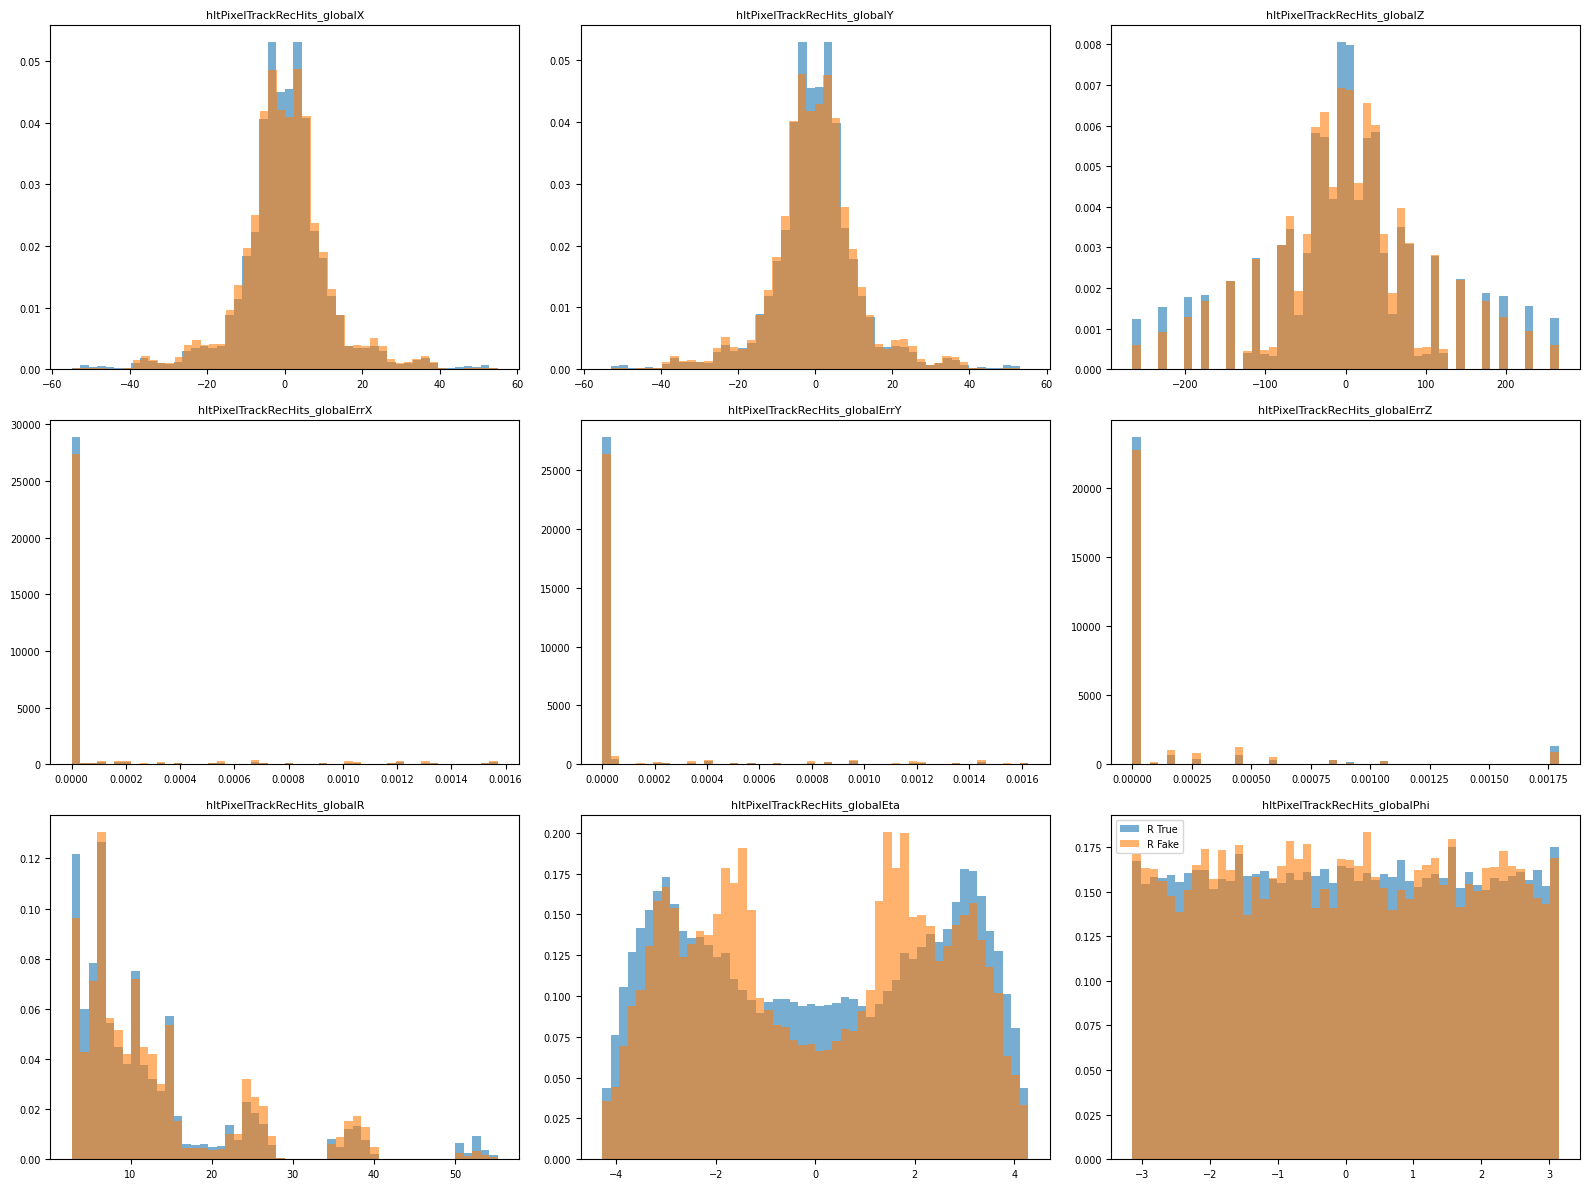

In [22]:
recHitFeatures_flat = np.array(masked_flatten(recHitFeatures, isRecHit)).T

# Optional: if you want to color by track label (e.g. true/fake track)
y_hits = np.repeat(recoPixelTrackLabels, isRecHit.sum(axis=1))  # only if you want to compare by label

plot_feature_distributions(
    X_ref=recHitFeatures_flat,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [23]:
log_recHit_vars = ["hltPixelTrackRecHits_globalR", "hltPixelTrackRecHits_globalErrX", "hltPixelTrackRecHits_globalErrY", "hltPixelTrackRecHits_globalErrZ"]
       
recHitFeatures_proc = recHitFeatures.copy()
for f, name in enumerate(recHitBranches):
    if name in log_recHit_vars:
        print(f, name)
        recHitFeatures_proc = masked_log_transform(recHitFeatures_proc, isRecHit, f, eps=EPSILON, method='log_eps')
        #recHitFeatures_proc = clip_outliers_3d(recHitFeatures_proc, isRecHit, f, 0.1, 0.99)

3 hltPixelTrackRecHits_globalErrX
4 hltPixelTrackRecHits_globalErrY
5 hltPixelTrackRecHits_globalErrZ
6 hltPixelTrackRecHits_globalR


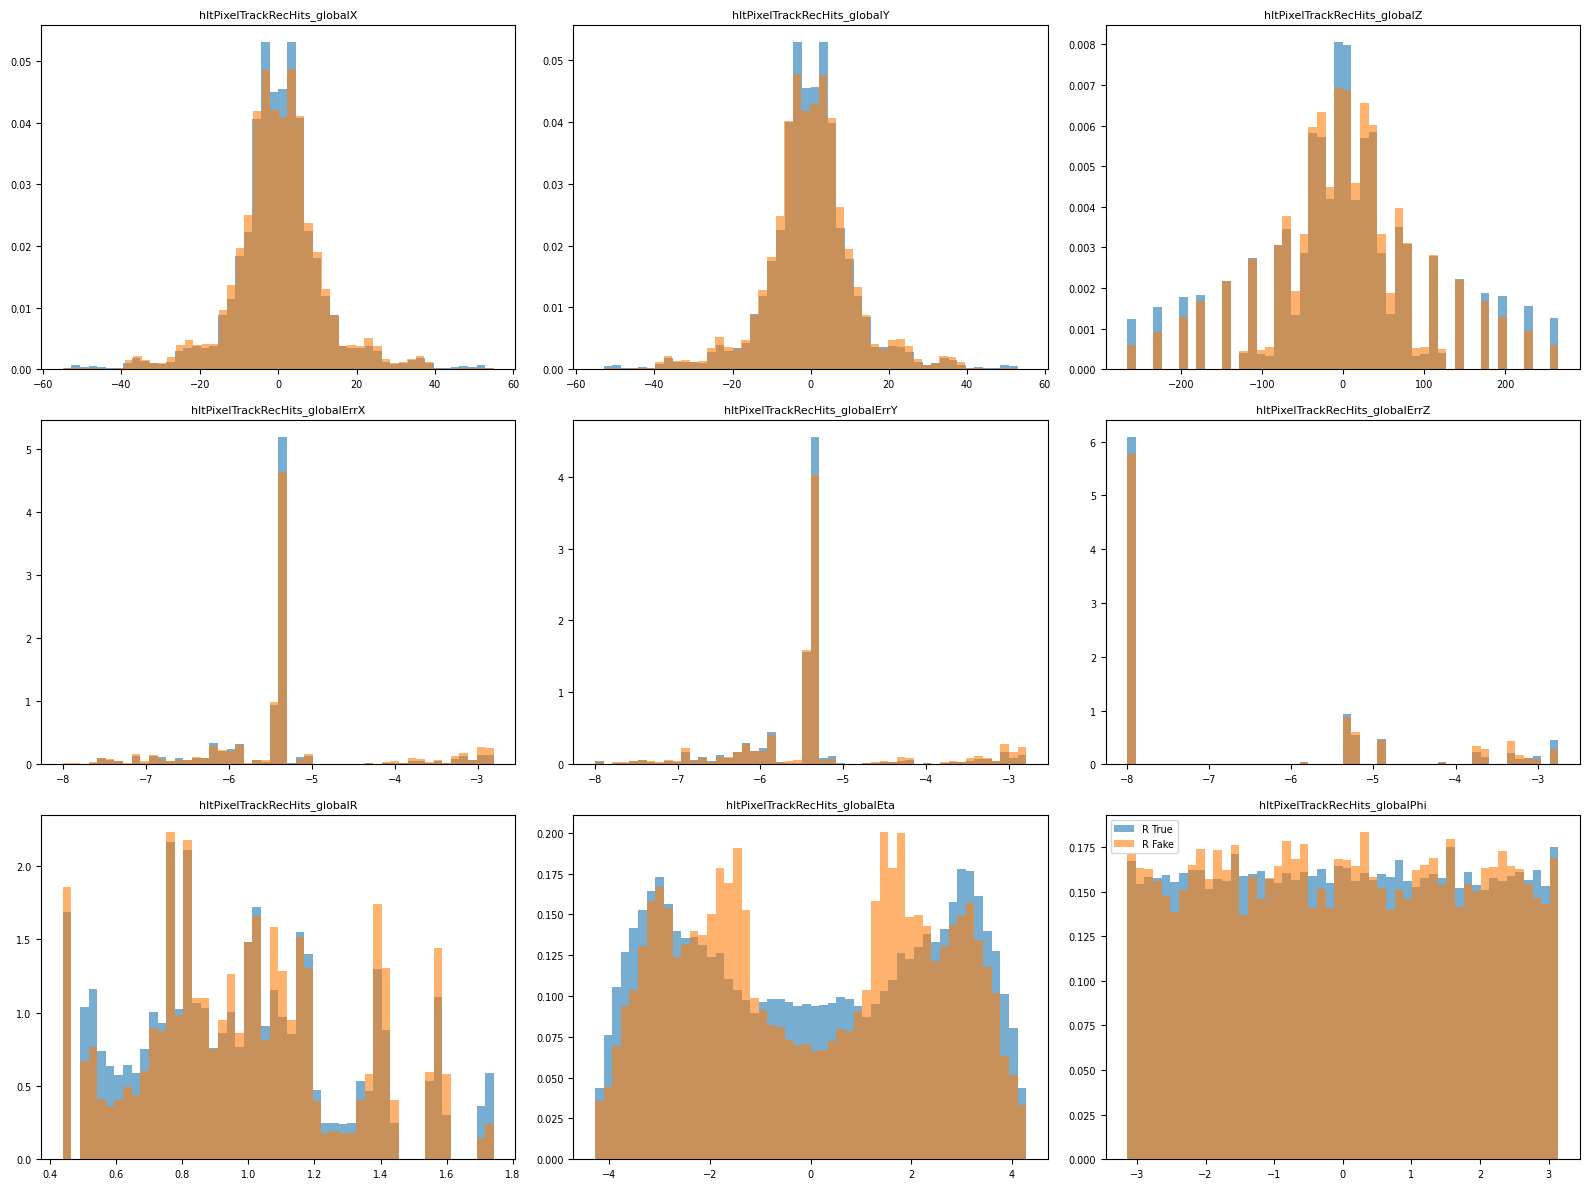

In [24]:
recHitFeatures_proc_plot = np.array(masked_flatten(recHitFeatures_proc, isRecHit)).T

plot_feature_distributions(
    X_ref=recHitFeatures_proc_plot,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

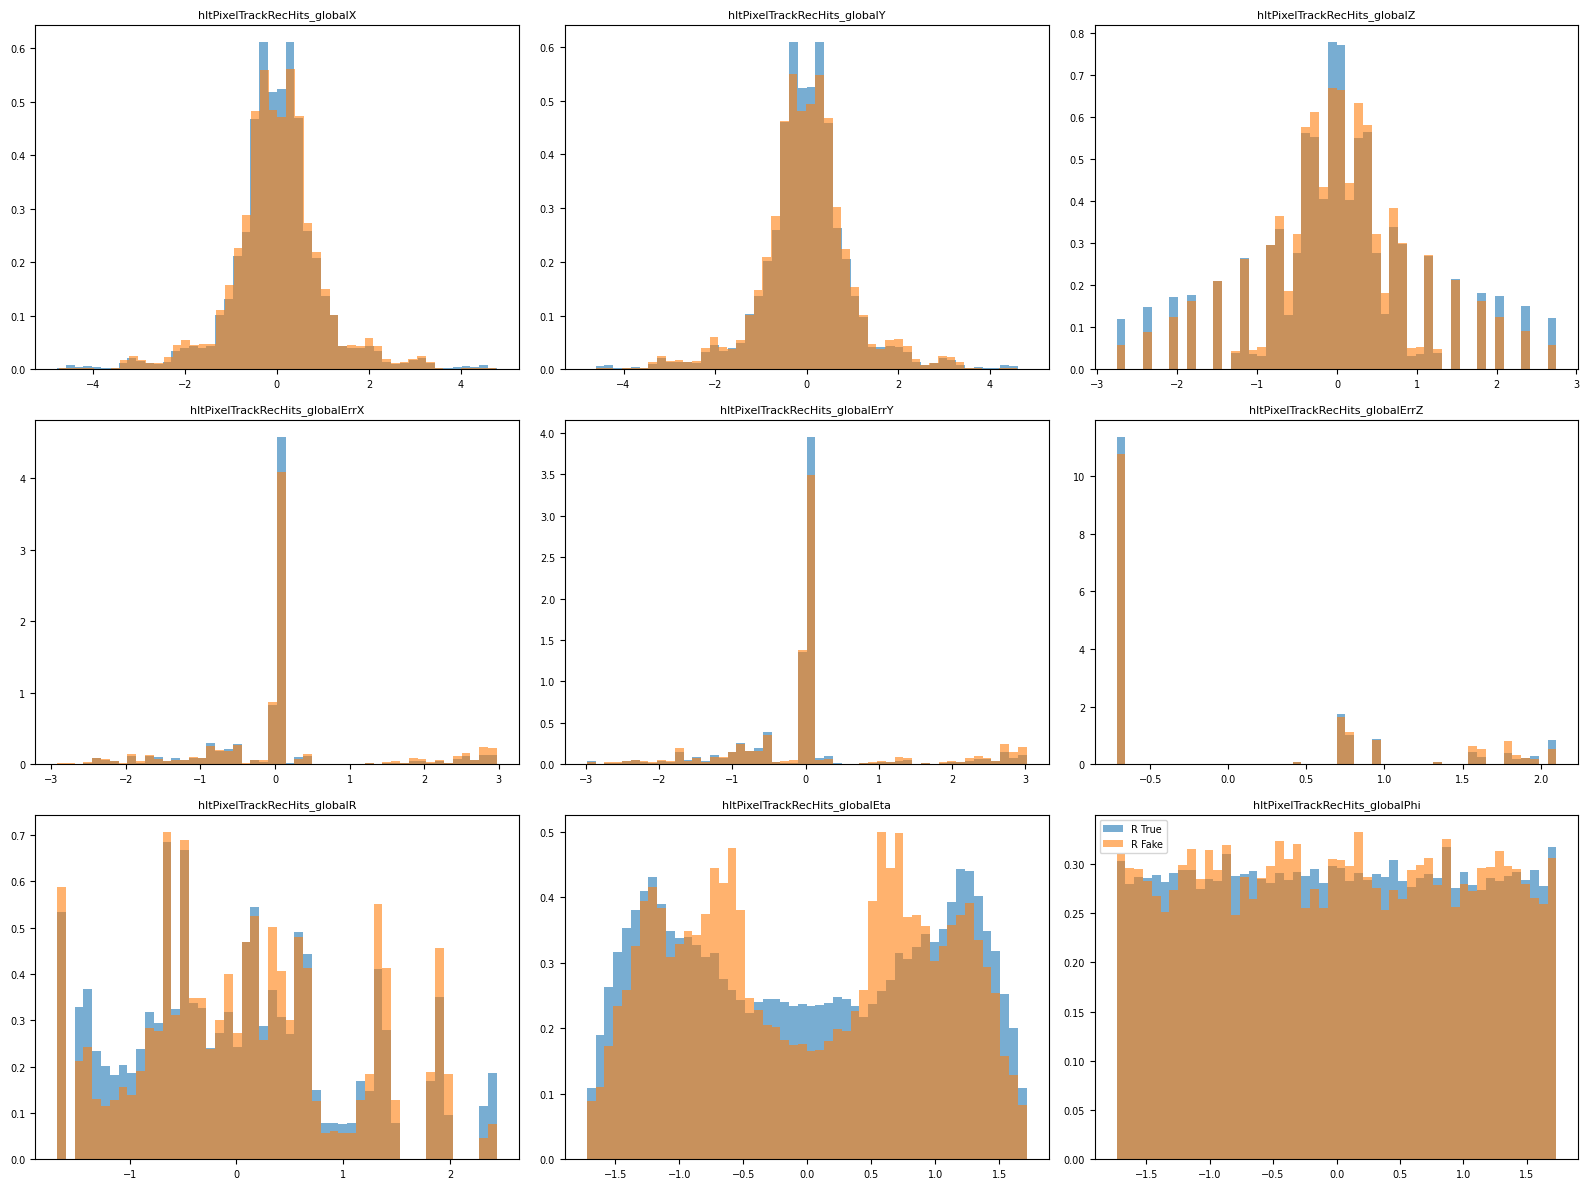

In [25]:
recHitFeatures_norm, recHit_mean, recHit_std = normalize_features_masked(recHitFeatures_proc, isRecHit, eps=EPSILON)

recHitFeatures_norm_plot = np.array(masked_flatten(recHitFeatures_norm, isRecHit)).T

plot_feature_distributions(
    X_ref=recHitFeatures_norm_plot,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [26]:
recHitFeatures_norm.shape

(182801, 16, 9)

## Data saving

In [27]:
save_dict = {
    # --- Core datasets ---
    "recHitFeatures": torch.tensor(recHitFeatures_norm, dtype=torch.float32),
    "isRecHit": torch.tensor(isRecHit, dtype=torch.bool),
    "recoPixelTrackFeatures": torch.tensor(recoPixelTrackFeaturesNorm, dtype=torch.float32),
    "labels": torch.tensor(recoPixelTrackLabels, dtype=torch.float32),
    "isHighPurity": torch.tensor(recoPixelTrackIsHighPurity, dtype=torch.bool),

    # --- Normalization stats ---
    "recHit_mean": torch.tensor(recHit_mean, dtype=torch.float32),
    "recHit_std": torch.tensor(recHit_std, dtype=torch.float32),
    "recoPixelTrack_mean": torch.tensor(recoPixelTrack_mean, dtype=torch.float32),
    "recoPixelTrack_std": torch.tensor(recoPixelTrack_std, dtype=torch.float32),

    # --- Metadata ---
    "recHitBranches": recHitBranches,
    "recoPixelTrackBranches": recoPixelTrackBranches[2:],  # exclude label and isHP
    "MAX_HITS": MAX_HITS,
    "EPSILON": EPSILON,
    "LOW_PERCENTILE": LOW_PERCENTILE,
    "HIGH_PERCENTILE": HIGH_PERCENTILE,
    "log_vars": log_vars,
    "clip_vars": clip_vars,
    "log_recHit_vars": log_recHit_vars
}

torch.save(save_dict, OUTPUT_PATH)
print(f"✅ Saved preprocessed dataset and parameters to {OUTPUT_PATH}")

✅ Saved preprocessed dataset and parameters to /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train-val_dataset.pt


In [28]:
!pip install -e ../TrackSelectorDNN/ &> /tmp/install.log

In [29]:
from torch.utils.data import random_split
from TrackSelectorDNN.data_manager.dataset import TrackDatasetFromFile

In [31]:
val_fraction = 0.2
dataset_len = len(save_dict["labels"])
val_len = int(dataset_len * val_fraction)
train_len = dataset_len - val_len

indices = torch.randperm(dataset_len, generator=torch.Generator().manual_seed(42))
train_idx, val_idx = indices[:train_len], indices[train_len:]

def subset_dict(save_dict, indices):
    subset = {}
    # Only split the core dataset tensors
    for key in ["recHitFeatures", "isRecHit", "recoPixelTrackFeatures", "labels", "isHighPurity"]:
        subset[key] = save_dict[key][indices]
    
    # Copy metadata and normalization stats as-is
    for key in ["recHit_mean", "recHit_std", "recoPixelTrack_mean", "recoPixelTrack_std",
                "recHitBranches", "recoPixelTrackBranches", "MAX_HITS", "EPSILON",
                "LOW_PERCENTILE", "HIGH_PERCENTILE", "log_vars", "clip_vars", "log_recHit_vars"]:
        subset[key] = save_dict[key]
    
    return subset

train_dict = subset_dict(save_dict, train_idx)
val_dict = subset_dict(save_dict, val_idx)

torch.save(train_dict, OUTPUT_PATH_TRAIN)
torch.save(val_dict, OUTPUT_PATH_VAL)
print(f"✅ Saved train and validation datasets with metadata")


✅ Saved train and validation datasets with metadata


In [33]:
!pwd

/eos/home-i03/e/ecoradin/GitHub/TrackSelectorDNN
